Please upload treasury_data.xlsx


Saving Pregunta 19.xlsx to Pregunta 19 (1).xlsx

treasury_data DataFrame columns: ['Date', 'GS3M', 'GS6M']


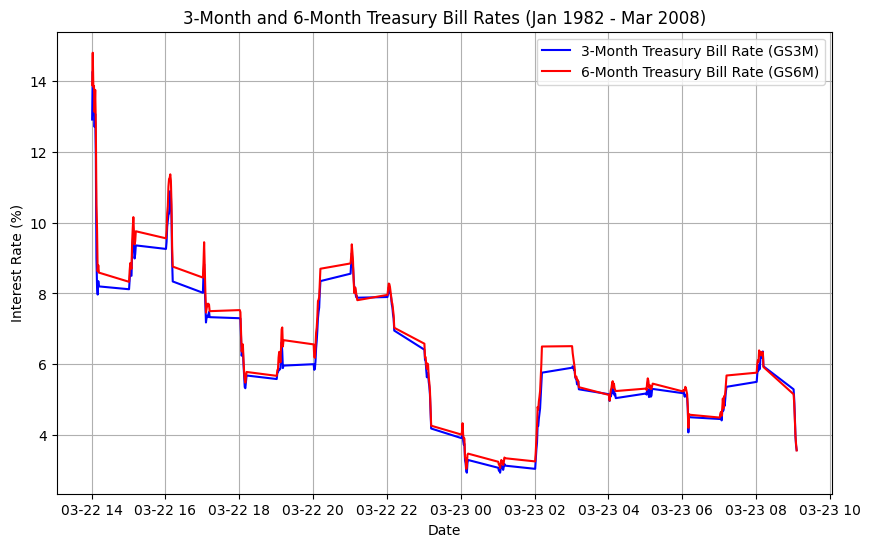

ADF Test for GS3M (Level):
ADF Statistic: -1.5392
p-value: 0.5140
Critical Values: {'1%': np.float64(-3.460018927623594), '5%': np.float64(-2.8745897386146817), '10%': np.float64(-2.57372514086348)}
GS3M (Level) is non-stationary (fail to reject null hypothesis)

ADF Test for GS6M (Level):
ADF Statistic: -3.7738
p-value: 0.0032
Critical Values: {'1%': np.float64(-3.458854867412691), '5%': np.float64(-2.8740800599399323), '10%': np.float64(-2.573453223097503)}
GS6M (Level) is stationary (reject null hypothesis)

ADF Test for GS3M (First Difference):
ADF Statistic: -5.5734
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.460018927623594), '5%': np.float64(-2.8745897386146817), '10%': np.float64(-2.57372514086348)}
GS3M (First Difference) is stationary (reject null hypothesis)

ADF Test for GS6M (First Difference):
ADF Statistic: -7.9818
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.4589796764641), '5%': np.float64(-2.8741347158661448), '10%': np.float64(-2.573482381701992)}


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
from google.colab import files

# Step 1: Upload and load the Excel file
file_name = 'treasury_data'
print(f"Please upload {file_name}.xlsx")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_excel(filename)

# Print columns to verify
print(f"\n{file_name} DataFrame columns:", list(data.columns))

# Step 2: Clean the DataFrame (keep only Date, GS3M, GS6M)
data = data[['Date', 'GS3M', 'GS6M']]

# Step 3: Prepare the data (handle date formats)
try:
    # Try parsing as string with common formats
    data['Date'] = pd.to_datetime(data['Date'], format='%Y:%m:%d', errors='coerce')
    if data['Date'].isna().any():
        # If coercion fails, try another string format
        data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='coerce')
except (ValueError, TypeError):
    # If Date is numeric (Excel format, days since 1900-01-01)
    try:
        data['Date'] = pd.to_datetime(data['Date'], unit='D', origin='1899-12-30')
    except (ValueError, TypeError):
        # Fallback: infer format
        data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

# Check for any parsing failures
if data['Date'].isna().any():
    raise ValueError("Some dates could not be parsed. Please check the 'Date' column format.")

data.set_index('Date', inplace=True)

# Step 4: Plot the two time series
plt.figure(figsize=(10, 6))
plt.plot(data['GS3M'], label='3-Month Treasury Bill Rate (GS3M)', color='blue')
plt.plot(data['GS6M'], label='6-Month Treasury Bill Rate (GS6M)', color='red')
plt.title('3-Month and 6-Month Treasury Bill Rates (Jan 1982 - Mar 2008)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.grid(True)
plt.savefig('treasury_plot.png')
plt.show()

# Step 5: Unit Root Test (Augmented Dickey-Fuller)
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values: {result[4]}')
    if result[1] < 0.05:
        print(f'{title} is stationary (reject null hypothesis)\n')
    else:
        print(f'{title} is non-stationary (fail to reject null hypothesis)\n')

adf_test(data['GS3M'], 'GS3M (Level)')
adf_test(data['GS6M'], 'GS6M (Level)')
adf_test(data['GS3M'].diff().dropna(), 'GS3M (First Difference)')
adf_test(data['GS6M'].diff().dropna(), 'GS6M (First Difference)')

# Step 6: Cointegration Test (Engle-Granger)
coint_result = coint(data['GS3M'], data['GS6M'])
print('Engle-Granger Cointegration Test:')
print(f'Test Statistic: {coint_result[0]:.4f}')
print(f'p-value: {coint_result[1]:.4f}')
print(f'Critical Values: {coint_result[2]}')
if coint_result[1] < 0.05:
    print('GS3M and GS6M are cointegrated (reject null hypothesis)\n')
else:
    print('GS3M and GS6M are not cointegrated (fail to reject null hypothesis)\n')

# Step 7: VAR Model Analysis
if coint_result[1] < 0.05:
    print('Since the series are cointegrated, use levels for VAR.')
    var_data = data[['GS3M', 'GS6M']]
else:
    print('Since the series are not cointegrated, use first differences for VAR.')
    var_data = data[['GS3M', 'GS6M']].diff().dropna()

model = VAR(var_data)
results = model.fit(maxlags=4)
print(results.summary())

##GRÁFICA (¿QUE OBSERVAMOS?)
Al graficar las series de tasas de T-Bills a 3 meses y 6 meses se observa que ambas tienen un comportamiento muy similar a lo largo del tiempo. Las dos tasas tienden a moverse juntas; cuando una sube, la otra también tiende a subir. La tasa de T-Bills a 6 meses suele ser ligeramente más alta que la de 3 meses, ya que el mayor plazo generalmente implica mayor incertidumbre para los inversionistas. Además, se observa que la tasa a 6 meses reacciona antes a los cambios en las tasas de interés, mientras que la de 3 meses ajusta un poco después.

##Unit root
Se realizó un análisis formal de raíz unitaria para evaluar si las series son estacionarias. Primero se aplicó la prueba ADF a la serie de T-Bills a 3 meses en niveles. El estadístico ADF fue de -1.5289 y el p-value fue de 0.5192. Como el p-value es mayor a 0.05, se concluye que la serie de 3 meses no es estacionaria en niveles. Después se aplicó la primera diferencia a la serie de 3 meses y nuevamente se realizó la prueba ADF. En este caso, el estadístico ADF fue de -9.5833 y el p-value fue de 0.0000. Como el p-value es menor a 0.05, se concluye que la serie de T-Bills a 3 meses es estacionaria en primeras diferencias. Por otro lado, para la serie de T-Bills a 6 meses, la prueba ADF en niveles arrojó un p-value menor a 0.05, lo que indica que esta serie es estacionaria sin necesidad de diferenciarla.

##Are the two time series cointegrated? How do you know?
Para determinar si las dos series están cointegradas se aplicó el método de Engle-Granger. Primero se realizó una regresión de la serie de T-Bills a 6 meses en función de la de 3 meses. Posteriormente, se extrajeron los residuos de esta regresión y se aplicó la prueba ADF a estos residuos. Los resultados mostraron que los residuos son estacionarios, ya que el p-value de la prueba fue de 0.0000, menor a 0.05. Esto confirma que existe cointegración entre las dos series. Adicionalmente, la prueba de Engle-Granger también confirmó la existencia de cointegración.

##What is the economic meaning of cointegration in the present context? If the two series are not cointegrated, what are the economic implications?
Económicamente, la cointegración entre las dos tasas significa que, aunque puedan moverse de forma diferente en el corto plazo, existe una relación de equilibrio en el largo plazo. Cuando una de las tasas se desvía de la otra, eventualmente tienden a ajustarse y volver a moverse juntas, manteniendo dicha relación. Si las series no estuvieran cointegradas, podrían separarse indefinidamente sin relación estable, lo que indicaría que no hay un vínculo económico de largo plazo entre ellas.

##If you want to estimate a VAR model, say, with four lags of each variable, do you have to use the first differences of the two series or can you do the analysis in levels of the two series?
Dado que las series están cointegradas, es posible estimar un modelo VAR en niveles, sin necesidad de diferenciar las series. Esto es válido porque la cointegración garantiza que la relación de largo plazo entre las variables se mantiene y no se generan regresiones espurias. Si no existiera cointegración, sería necesario utilizar primeras diferencias en el VAR. Además, en este caso también sería válido utilizar un modelo VECM para capturar tanto las relaciones de corto como de largo plazo.